# Transfer learning with TensorFlow Hub


[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models.



## 1. Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# 2. Load dataset


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [4]:
# featurewise_std_normalization
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory('../data/spectrograms224_aug', class_mode="categorical",batch_size=6000, target_size=(224, 224))

Found 6000 images belonging to 10 classes.


In [5]:
labels = (image_data.class_indices)
labels

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [6]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (6000, 224, 224, 3)
Label batch shape:  (6000, 10)


# 3. Split in test and train dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_batch, 
                                                    label_batch, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    stratify = label_batch)


# 4. Download the headless model

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [8]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the feature extractor.

In [13]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a vector for each image:

In [14]:
feature_batch = feature_extractor_layer(X_train[:1000])
print(feature_batch.shape)

(1000, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [15]:
feature_extractor_layer.trainable = False

# 4. Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [16]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


# 5. Train the model

Use compile to configure the training process:

In [17]:
model.compile(
  optimizer=tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
  #optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True),
  #optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
  loss='categorical_crossentropy',
  metrics=['acc'])

Now use the `.fit` method to train the model.

To visualize the training progress, use a custom callback to log the loss and accuracy of each epoch.

In [18]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    self.batch_acc_test = []
    self.batch_losses_test = []


    
  def on_epoch_end (self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.batch_acc_test.append(logs['val_acc'])
    self.batch_losses_test.append(logs['val_loss'])
    self.model.reset_metrics()

In [23]:
steps_per_epoch = 800 

batch_stats_callback = CollectBatchStats()

history = model.fit(X_train, y_train, epochs=900,
                              batch_size = 32,
                              steps_per_epoch = 10,
                              shuffle=True,
                              callbacks = [batch_stats_callback],
                              validation_data=(X_test, y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/900
 320/4800 [=>............................] - ETA: 1:03 - loss: 0.3571 - acc: 0.9031

KeyError: 'val_acc'

# 6. Plot accuracy and loss

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

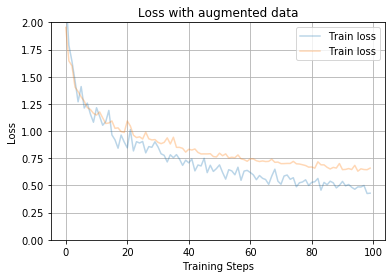

In [20]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses, label= 'Train loss', alpha=0.3)
plt.plot(batch_stats_callback.batch_losses_test, label= 'Train loss', alpha=0.3)
plt.legend(loc="upper right")
plt.title("Loss with augmented data")
plt.grid(True)

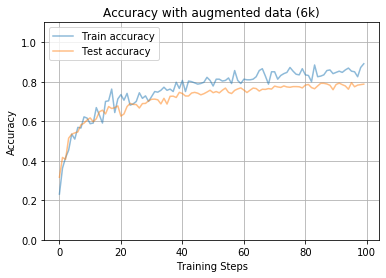

In [22]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1.1])
plt.plot(batch_stats_callback.batch_acc, label= 'Train accuracy', alpha=0.5)
plt.plot(batch_stats_callback.batch_acc_test, label= 'Test accuracy', alpha=0.5)
plt.legend(loc="upper left")
plt.title("Accuracy with augmented data (6k)")
plt.grid(True)

# 7. Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

Run the image batch through the model and convert the indices to class names.

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [ ]:
label_id = np.argmax(label_batch, axis=-1)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# 8. Export your model

Now that you've trained the model, export it as a saved model:

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Now confirm that we can reload it, and it still gives the same results:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

